In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from utils import *

from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Activation, GlobalMaxPooling1D, Input, Conv2D, Reshape, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

from gensim.models import Word2Vec

In [6]:
df = pd.read_csv("cleaned_data/cleaned_reviews_3.csv")
df

,review,text,rating,sentiment
0,Ugh I hated the last book in this series- what...,"['ugh', 'hat', 'last', 'book', 'in', 'series',...",1,0
1,"This started out strong, but it went downhill ...","['start', 'out', 'strong', 'but', 'go', 'downh...",1,0
2,"A decently written YA book, but I can't even c...","['decently', 'write', 'ya', 'book', 'but', 'ca...",1,0
3,This book simultaneously bored me to death and...,"['book', 'simultaneously', 'bore', 'death', 'a...",1,0
4,"Ugh...I tried, I honestly tried. I'm a huge fa...","['ugh', 'try', 'honestly', 'try', 'huge', 'fan...",1,0
...,...,...,...,...
11395,"I knew from the moment I read ""Someone lives a...","['know', 'moment', 'read', 'someone', 'live', ...",5,1
11396,Originally at The Secret Life of a Bookworm \n...,"['originally', 'secret', 'life', 'bookworm', '...",5,1
11397,"AHHHHHHH MY KAIDAN, OHHH KAIDAN!!!!!!!!!! \n A...","['ahhhhhhh', 'kaidan', 'ohhh', 'kaidan', 'awww...",5,1
11398,This is my kind of book. It carefully touched ...,"['kind', 'book', 'carefully', 'touch', 'theme'...",5,1


In [7]:
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review,text,rating,sentiment,detoken
0,Ugh I hated the last book in this series- what...,"[ugh, hat, last, book, in, series, poor, way, ...",1,0,ugh hat last book in series poor way end trilogy
1,"This started out strong, but it went downhill ...","[start, out, strong, but, go, downhill, fairly...",1,0,start out strong but go downhill fairly quickl...
2,"A decently written YA book, but I can't even c...","[decently, write, ya, book, but, can, even, co...",1,0,decently write ya book but can even consider e...
3,This book simultaneously bored me to death and...,"[book, simultaneously, bore, death, annoy, hel...",1,0,book simultaneously bore death annoy hell out ...
4,"Ugh...I tried, I honestly tried. I'm a huge fa...","[ugh, try, honestly, try, huge, fan, scott, we...",1,0,ugh try honestly try huge fan scott westerfeld...


In [12]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 1003)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")

There are 825119 train words in total and the vocabulary size is 24637.


In [9]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# max_length = max(max([len(x) for x in train_sequences]), max([len(x) for x in test_sequences]))
max_length = 200

x_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(max_length)
print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

200
(9120, 200)
(2280, 200)
(9120,)
(2280,)
Found 24513 unique tokens


In [10]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [11]:
def vocab_build(review_set):

    vocab = Counter()

    for review in review_set:
        for token in review:
            vocab[token] += 1

    return vocab

def embedding_coverage(review_set, embeddings_dict):
    
    vocab = vocab_build(review_set)

    covered = {}
    word_count = {}
    oov = {}
    covered_num = 0
    oov_num = 0

    for word in vocab:
        try:
            covered[word] = embeddings_dict[word]
            covered_num += vocab[word]
            word_count[word] = vocab[word]
        
        except:
            oov[word] = vocab[word]
            oov_num += oov[word]

    vocab_coverage = len(covered) / len(vocab) * 100
    text_coverage = covered_num / (covered_num + oov_num) * 100
    
    return word_count, oov, vocab_coverage, text_coverage

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(df_train["text"], embeddings_dict)
test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test["text"],embeddings_dict)

print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in testing set")

Glove embeddings cover 94.17% of vocabulary and 99.75% text in training set
Glove embeddings cover 94.81% of vocabulary and 99.54% text in testing set


In [24]:
EMBEDDING_DIM = 300
MAX_WORDS = 20000
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=True)

del(embedding_matrix)

In [27]:
sequence_input = Input(shape=(max_length,), dtype="int32")
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(256, 10, activation="relu")(embedded_sequences)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 300)          6000000   
                                                                 
 conv1d_5 (Conv1D)           (None, 191, 256)          768256    
                                                                 
 bidirectional (Bidirectiona  (None, 191, 256)         394240    
 l)                                                              
                                                                 
 lstm_7 (LSTM)               (None, 64)                82176     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                           

In [28]:
# Compile model

EPOCHS = 10
LEARNING_RATE = 0.0001
# DECAY_RATE = LEARNING_RATE / EPOCHS

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [30]:
# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/10
200/200 [==============================] - 252s 1s/step - loss: 0.6503 - accuracy: 0.6412 - val_loss: 0.9575 - val_accuracy: 0.1134
Epoch 2/10
200/200 [==============================] - 218s 1s/step - loss: 0.6306 - accuracy: 0.6548 - val_loss: 0.9628 - val_accuracy: 0.1422
Epoch 3/10
200/200 [==============================] - 186s 932ms/step - loss: 0.6152 - accuracy: 0.6692 - val_loss: 0.8024 - val_accuracy: 0.1988
Epoch 4/10
200/200 [==============================] - 166s 833ms/step - loss: 0.6081 - accuracy: 0.6808 - val_loss: 0.9858 - val_accuracy: 0.1166
Epoch 5/10
200/200 [==============================] - 171s 858ms/step - loss: 0.6383 - accuracy: 0.6432 - val_loss: 0.9869 - val_accuracy: 0.1234
Epoch 6/10
200/200 [==============================] - 189s 948ms/step - loss: 0.6147 - accuracy: 0.6698 - val_loss: 0.8229 - val_accuracy: 0.1887
Epoch 7/10
200/200 [==============================] - 220s 1s/step - loss: 0.6324 - accuracy: 0.6543 - val_loss: 0.9577 - val_accu

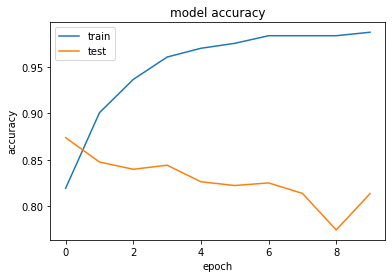

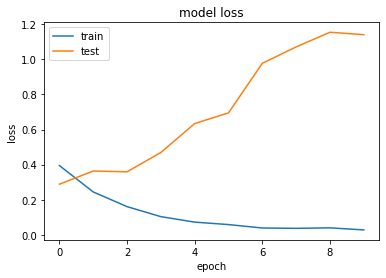

In [16]:
# Plot accuracy and loss
plot_history(history)

In [17]:
# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

125/125 - 13s - loss: 0.9092 - accuracy: 0.8562 - 13s/epoch - 108ms/step
Test accuracy: 0.856249988079071
